In [ ]:
#!pip install textblob

In [ ]:
#pip install -U pandas==1.3.4 --user

In [2]:
from tweepy import OAuthHandler
#from tweepy.streaming import StreamListener
import tweepy
import json
import pandas as pd
import csv
import re
#from textblob import TextBlob
import string
#import preprocessor as p
import os
import time
#from twarc import expansions

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, recall_score,precision_score, confusion_matrix, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import textblob
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

import tensorflow as tf
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from keras.optimizers import SGD
from tensorflow.keras import regularizers


import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\milad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
tweets_raw = pd.read_csv('tweets.csv')
tweets_raw.isna().sum()

id              0
text            0
withheld    30332
dtype: int64

In [5]:
nltk.download("vader_lexicon")

tweets_raw = pd.read_csv('tweets.csv')
tweets_raw.drop(columns=['id','withheld'], axis=1, inplace=True)
tweets_raw.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\milad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text
0,Elon Musk took over Twitter. If anyone doesn't...
1,Why is this Twitter buyout a good thing again?...
2,Elon Musk’s Twitter layoffs are starting https...
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek..."
4,«An email went out to the company’s employees ...


In [6]:
sentiments = SentimentIntensityAnalyzer()
tweets_raw["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in tweets_raw["text"]]
tweets_raw["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in tweets_raw["text"]]
tweets_raw["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in tweets_raw["text"]]
tweets_raw['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in tweets_raw["text"]]
tweets_raw.head()

,text,Positive,Negative,Neutral,Compound
0,Elon Musk took over Twitter. If anyone doesn't...,0.00,0.000,1.000,0.0000
1,Why is this Twitter buyout a good thing again?...,0.18,0.000,0.820,0.6199
2,Elon Musk’s Twitter layoffs are starting https...,0.00,0.000,1.000,0.0000
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",0.00,0.315,0.685,-0.3182
4,«An email went out to the company’s employees ...,0.00,0.050,0.950,-0.2732


In [7]:
score = tweets_raw["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
tweets_raw["Sentiment"] = sentiment
tweets_raw.head()

,text,Positive,Negative,Neutral,Compound,Sentiment
0,Elon Musk took over Twitter. If anyone doesn't...,0.00,0.000,1.000,0.0000,Neutral
1,Why is this Twitter buyout a good thing again?...,0.18,0.000,0.820,0.6199,Positive
2,Elon Musk’s Twitter layoffs are starting https...,0.00,0.000,1.000,0.0000,Neutral
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",0.00,0.315,0.685,-0.3182,Negative
4,«An email went out to the company’s employees ...,0.00,0.050,0.950,-0.2732,Negative


In [8]:
tweets_raw = tweets_raw[['text','Sentiment']]
tweets_raw.head()

,text,Sentiment
0,Elon Musk took over Twitter. If anyone doesn't...,Neutral
1,Why is this Twitter buyout a good thing again?...,Positive
2,Elon Musk’s Twitter layoffs are starting https...,Neutral
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",Negative
4,«An email went out to the company’s employees ...,Negative


In [9]:
tweets_raw['Sentiment'].value_counts()

Negative    12037
Neutral      9377
Positive     8921
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

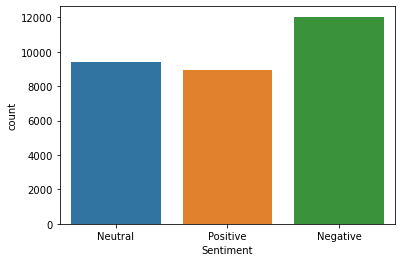

In [10]:
sns.countplot(tweets_raw['Sentiment'])

In [11]:
X=tweets_raw.text
y=tweets_raw.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
cv_dict = {}
def reportcrossval(model, model_name, X, Y):
    cv_mean = cross_val_score(model, X, Y).mean()
    cv_dict[model_name] = cv_mean
    print(f"The cv mean of {model_name} is {cv_mean}")

In [13]:
pipe_dummy = Pipeline([('dummy', DummyClassifier(strategy='most_frequent'))], verbose=True)

In [14]:
reportcrossval(pipe_dummy, 'Dummy', X_train, y_train)

[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
[Pipeline] ............. (step 1 of 1) Processing dummy, total=   0.0s
The cv mean of Dummy is 0.39776660009470016


# pre-processing

In [15]:
Stop_Words = stopwords.words('english')
Stop_Words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [16]:
def get_wordnet_pos(tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
import numpy as np

def Cleaning_tweets(df):
    '''
    This function will Clean the given dataframe from any URL's, Mentions, Hashtags, Punctuations, Numbers,etc.
    and also lemmitize the words and returns a dataframe with cleaned tweet as a new column.
    
    '''  
    stemmer = PorterStemmer()
    s_stemmer = nltk.stem.SnowballStemmer(language="english")
    lemmatizer = WordNetLemmatizer()
    
    Extended_Stop_Words = stopwords.words('english')
    Extended_Stop_Words.extend(['elon','musk','twitter'])
    
    def clean_tweet(tweet):
        if type(tweet) == np.float:
            return ""
        temp = tweet.lower() # lower case the text
        temp = re.sub("'", "", temp) # to avoid removing contractions in english
        temp = re.sub("@[A-Za-z0-9_]+","", temp) # removes mentions
        temp = re.sub("#[A-Za-z0-9_]+","", temp) # removes hashtags
        temp = re.sub('[0-9]+', '', temp)
        temp = re.sub(r'http\S+', '', temp) # removes URL's
        temp = re.sub('[()!?]', ' ', temp) # removes special charecters
        temp = re.sub('\[.*?\]',' ', temp) # further removes special charecters
        temp = re.sub("[^a-z0-9]"," ", temp)
        temp = temp.split() # splitting the words
#        temp = [s_stemmer.stem(w) for w in temp if not w in Stop_Words] # Removes the stop words and Stemming
        
#        temp = [(word, get_wordnet_pos(word)) for word in temp if not word in Stop_Words]
        temp = [lemmatizer.lemmatize(w) for w in temp if not w in Extended_Stop_Words] # Removes the stop words and Lemming
        temp = " ".join(word for word in temp) # join all words together
        return temp
    results = [clean_tweet(tw) for tw in list(df.text)] # iterete over each tweet and clean it based on above function
    df['Cleaned_Text'] = results
    return df 

In [18]:
Cleaning_tweets(tweets_raw)

,text,Sentiment,Cleaned_Text
0,Elon Musk took over Twitter. If anyone doesn't...,Neutral,took anyone doesnt want leave dont let door hi...
1,Why is this Twitter buyout a good thing again?...,Positive,buyout good thing also always resting smug fac...
2,Elon Musk’s Twitter layoffs are starting https...,Neutral,layoff starting
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",Negative,shocked
4,«An email went out to the company’s employees ...,Negative,email went company employee late thursday noti...
...,...,...,...
30330,'No choice': Elon Musk justifies mass layoffs ...,Negative,choice justifies mass layoff
30331,Here's why Binance's CZ invested in Twitter fo...,Neutral,here binances cz invested following acquisitio...
30332,Elon Musk says Twitter had ‘no choice’ over th...,Neutral,say choice thousand layoff company losing per day
30333,Thousands of staff at social media company Twi...,Neutral,thousand staff social medium company job new o...


In [19]:
tweets_raw.Cleaned_Text.iloc[4]

'email went company employee late thursday notifying employee plan cut job informing pacific time friday worker would receive email subject line role'

In [20]:
tweets_raw.text.iloc[4]

'«An email went out to the company’s employees late Thursday notifying employees of plans to cut jobs, informing them that by 9 a.m. Pacific time Friday, workers would receive an email with the subject line: “Your Role at Twitter.”» #Twitter #ChiefTwit  https://t.co/ypfkN5mHjS'

In [21]:
def Tokenizing_tweets(df):
    '''
    This function will Clean the given dataframe from any URL's, Mentions, Hashtags, Punctuations, Numbers,etc.
    and also lemmitize the words and returns a dataframe with cleaned tweet as a new column.
    
    '''  

    Extended_Stop_Words = stopwords.words('english')
    Extended_Stop_Words.extend(['elon','musk','twitter'])
    def clean_tweet(tweet):
        if type(tweet) == np.float:
            return ""
        temp = tweet.lower() # lower case the text
        temp = re.sub("'", "", temp) # to avoid removing contractions in english
        temp = re.sub("@[A-Za-z0-9_]+","", temp) # removes mentions
        temp = re.sub("#[A-Za-z0-9_]+","", temp) # removes hashtags
        temp = re.sub(r'http\S+', '', temp) # removes URL's
        temp = re.sub('[()!?]', ' ', temp) # removes special charecters
        temp = re.sub('\[.*?\]',' ', temp) # further removes special charecters
        temp = re.sub("[^a-z0-9]"," ", temp)
        temp = temp.split() # splitting the words
        temp = [w for w in temp if not w in Extended_Stop_Words] # Removes the stop words and Lemming
        return temp
    results = [clean_tweet(tw) for tw in list(df.text)] # iterete over each tweet and clean it based on above function
    df['Tokenized_Text'] = results
    return df 

In [22]:
Tokenizing_tweets(tweets_raw)

,text,Sentiment,Cleaned_Text,Tokenized_Text
0,Elon Musk took over Twitter. If anyone doesn't...,Neutral,took anyone doesnt want leave dont let door hi...,"[took, anyone, doesnt, wants, leave, dont, let..."
1,Why is this Twitter buyout a good thing again?...,Positive,buyout good thing also always resting smug fac...,"[buyout, good, thing, also, always, resting, s..."
2,Elon Musk’s Twitter layoffs are starting https...,Neutral,layoff starting,"[layoffs, starting]"
3,"Elon Musk is shocked\n\n@AntonioIvanchev,@tsek...",Negative,shocked,[shocked]
4,«An email went out to the company’s employees ...,Negative,email went company employee late thursday noti...,"[email, went, company, employees, late, thursd..."
...,...,...,...,...
30330,'No choice': Elon Musk justifies mass layoffs ...,Negative,choice justifies mass layoff,"[choice, justifies, mass, layoffs]"
30331,Here's why Binance's CZ invested in Twitter fo...,Neutral,here binances cz invested following acquisitio...,"[heres, binances, cz, invested, following, acq..."
30332,Elon Musk says Twitter had ‘no choice’ over th...,Neutral,say choice thousand layoff company losing per day,"[says, choice, thousands, layoffs, company, lo..."
30333,Thousands of staff at social media company Twi...,Neutral,thousand staff social medium company job new o...,"[thousands, staff, social, media, company, job..."


In [23]:
Positive_sent = tweets_raw[tweets_raw['Sentiment']=='Positive']
Negative_sent = tweets_raw[tweets_raw['Sentiment']=='Negative']
Neutral_sent = tweets_raw[tweets_raw['Sentiment']=='Neutral']

In [24]:
#MosT common positive words
from collections import Counter

top = Counter([item for sublist in Positive_sent['Tokenized_Text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,like,1349
1,free,879
2,people,794
3,help,762
4,please,736
5,speech,733
6,need,676
7,get,628
8,employees,556
9,musks,512


In [25]:
#MosT common positive words
from collections import Counter

top = Counter([item for sublist in Negative_sent['Tokenized_Text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Reds')

,Common_words,count
0,employees,1571
1,layoffs,1252
2,staff,1029
3,via,908
4,fired,905
5,people,904
6,advertisers,748
7,company,743
8,new,733
9,half,707


In [26]:
#MosT common positive words
from collections import Counter

top = Counter([item for sublist in Neutral_sent['Tokenized_Text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Blues')

,Common_words,count
0,layoffs,2018
1,mass,1140
2,employees,916
3,musks,893
4,begin,752
5,staff,741
6,takeover,676
7,via,657
8,friday,486
9,begins,480


In [27]:
X=tweets_raw.Cleaned_Text
y=tweets_raw.Sentiment
y_NN=pd.get_dummies(tweets_raw.Sentiment)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X, y_NN, test_size=0.2, random_state=42)

In [28]:
def display_cross_validation_results(cross_val,model_name):
    '''
    Incoporate cross validation results into a pandas dataframe and display validation scores
    '''
    
    cross_val_results = pd.DataFrame(cross_val)
    
    accuracy = cross_val_results['mean_test_accuracy'][0]
    recall = cross_val_results['mean_test_recall'][0]
    precision = cross_val_results['mean_test_precision'][0]
    
    print('Validation','='*60)
    print(f'Validation results for {model_name}:')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}\n')

In [29]:
def display_prediction_results(prediction, actuall, model_name):
    '''
    Get predictions for X_test samples and display scores
    '''
    
    accuracy = accuracy_score(actuall,prediction)
    recall = recall_score(actuall, prediction, average = 'micro')
    precision = precision_score(actuall, prediction, average = 'micro')
#    roc_auc_score = roc_auc_score(actuall, prediction,  average = 'micro')

    print('='*60)
    print(f'Predictions for: {model_name}')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
#    print(f'Roc_AUC Score: {roc_auc_score}\n')

In [30]:
def display_confusion_matrix_v2(actuall_y,predicted_y,model_name):
    conf_matrix = confusion_matrix(y_true=actuall_y, y_pred=predicted_y)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
    plt.xlabel('Predictions', fontsize=14)
    plt.ylabel('Actuals', fontsize=14)
    plt.title(f'Confusion Matrix for {model_name}');
    save_image_as = 'confusion_matrix_' + '_'.join(model_name.split()) + ': ' 
    fig.savefig(save_image_as)
    

In [31]:
def display_confusion_matrix(model, X, y, model_name):
    print(f'Confusion Matrix for Model: {model_name}')
    plot_confusion_matrix(model,X,y)
    print('='*80)
    

# TF_IDF Vectorizer

In [234]:
# MultinomialNB
# Use pipes to TF_IDF Vectorize X_train and then train MultinomialNB

start = time.time()

TF_mnb_pipe = Pipeline([('tfidfvect',TfidfVectorizer()), 
                 ('mnb', MultinomialNB())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

TF_mnb_params = {'tfidfvect__input' : ['content'],
                 'tfidfvect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                 'mnb__alpha' : [1.0]}

TF_mnb_model_grid = GridSearchCV(estimator = TF_mnb_pipe, param_grid = TF_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

TF_mnb_model_grid.fit(X_train,y_train)
display(TF_mnb_model_grid.best_score_)
display(TF_mnb_model_grid.best_params_)
#end = time.time()
#print(f'Training time: {end-start}')

0.7138206917490411

{'mnb__alpha': 1.0,
 'tfidfvect__input': 'content',
 'tfidfvect__ngram_range': (1, 1)}

In [237]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with TF-IDF Vectorize'

display_cross_validation_results(TF_mnb_model_grid.cv_results_,model_name)

y_hat_TF_MNB = TF_mnb_model_grid.predict(X_test)

display_prediction_results(y_hat_TF_MNB, y_test,model_name)


Validation ============================================================
Validation results for MultinomialNB with TF-IDF Vectorize:
Accuracy: 0.7138206917490411
Recall: 0.7138206917490411
Precision: 0.7138206917490411

Predictions for: MultinomialNB with TF-IDF Vectorize
Accuracy: 0.7301796604582166
Recall: 0.7301796604582166
Precision: 0.7301796604582166


Confusion Matrix for Model: MultinomialNB with TF-IDF Vectorize


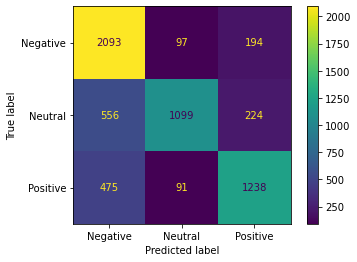

In [238]:
display_confusion_matrix(TF_mnb_model_grid, X_test,
                         y_test,model_name)

In [ ]:
results_df = pd.DataFrame(y_test)
results_df['tweet_text'] = X_test
y_pred_proba = TF_mnb_model_grid.predict_proba(X_test)
y_pred_proba = pd.DataFrame(data = y_pred_proba, columns = ['pred_NG','pred_NU','pred_PS'])
results_df.insert(loc = 2, column = 'pred_NG' , value = y_pred_proba['pred_NG'].values)
results_df.insert(loc = 3, column = 'pred_NU' , value = y_pred_proba['pred_NU'].values)
results_df.insert(loc = 4, column = 'pred_PS' , value = y_pred_proba['pred_PS'].values)
results_df.insert(loc = 5, column = 'pred' , value = y_hat_TF_MNB)

In [ ]:
results_df

In [ ]:
errors_df = results_df[results_df['Sentiment'] != results_df['pred']]
errors_df

In [ ]:
false_neg_df = errors_df[errors_df['Sentiment'] == 'Positive']
false_neg_df_sort = false_neg_df.sort_values(by = 'pred_PS')

false_neg_df_sort

In [ ]:
most_confident_false_neg = false_neg_df_sort.iloc[0:6].tweet_text.values

most_confident_false_neg

In [239]:
# LogisticRegression
# Use pipes to TF_IDF Vectorize X_train and then train LogisticRegression

TF_LR_pipe = Pipeline([('tfidfvect',TfidfVectorizer()), 
                 ('lr', LogisticRegression())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

TF_LR_params = {'tfidfvect__input' : ['content'],
                 'tfidfvect__ngram_range': [(1, 2)],
                 'lr__penalty' : ['l1'],
                'lr__C' : [100],  # tried 1 and 100
                'lr__class_weight' : [None],  # tried None and 'balanced'
                'lr__solver' : ['liblinear'], # tried 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
                'lr__max_iter' : [1000]} # treid 100,1000

TF_LR_model_grid = GridSearchCV(estimator = TF_LR_pipe, param_grid = TF_LR_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

TF_LR_model_grid.fit(X_train,y_train)
display(TF_LR_model_grid.best_score_)
display(TF_LR_model_grid.best_params_)
#end = time.time()
#print(f'Training time: {end-start}')

0.8494730150902967

{'lr__C': 100,
 'lr__class_weight': None,
 'lr__max_iter': 1000,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear',
 'tfidfvect__input': 'content',
 'tfidfvect__ngram_range': (1, 2)}

In [240]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'Logistic Regression with TF-IDF Vectorize'

display_cross_validation_results(TF_LR_model_grid.cv_results_,model_name)

y_hat_TF_LR = TF_LR_model_grid.predict(X_test)

display_prediction_results(y_hat_TF_LR, y_test,model_name)


Validation ============================================================
Validation results for Logistic Regression with TF-IDF Vectorize:
Accuracy: 0.8494730150902967
Recall: 0.8494730150902967
Precision: 0.8494730150902967

Predictions for: Logistic Regression with TF-IDF Vectorize
Accuracy: 0.8633591560903247
Recall: 0.8633591560903247
Precision: 0.8633591560903247


Confusion Matrix for Model: Logistic Regression with TF-IDF Vectorize


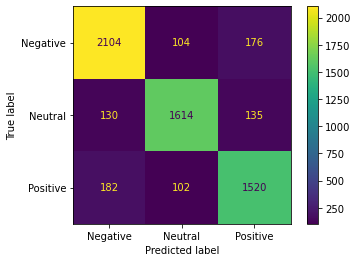

In [241]:
display_confusion_matrix(TF_LR_model_grid, X_test,
                         y_test,model_name)

# Count Vectorizer

In [242]:
# MultinomialNB
# Use pipes to Count Vectorize X_train and then train MultinomialNB

start = time.time()

CT_mnb_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('mnb', MultinomialNB())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_mnb_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                 'mnb__alpha' : [1.0]}

CT_mnb_model_grid = GridSearchCV(estimator = CT_mnb_pipe, param_grid = CT_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_mnb_model_grid.fit(X_train,y_train)
display(CT_mnb_model_grid.best_score_)
display(CT_mnb_model_grid.best_params_)
#end = time.time()
#print(f'Training time: {end-start}')

0.7265948426380838

{'countvect__input': 'content',
 'countvect__ngram_range': (1, 3),
 'mnb__alpha': 1.0}

In [243]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with Count Vectorize'

display_cross_validation_results(CT_mnb_model_grid.cv_results_,model_name)

y_hat_CT_MNB = CT_mnb_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_MNB, y_test,model_name)

Validation ============================================================
Validation results for MultinomialNB with Count Vectorize:
Accuracy: 0.7108949807488069
Recall: 0.7108949807488069
Precision: 0.7108949807488069

Predictions for: MultinomialNB with Count Vectorize
Accuracy: 0.7389154442063622
Recall: 0.7389154442063622
Precision: 0.7389154442063622


Confusion Matrix for Model: MultinomialNB with Count Vectorize


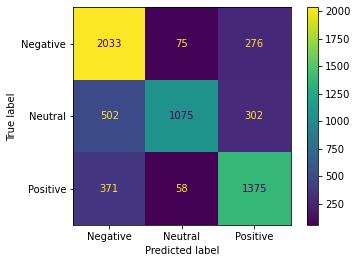

In [244]:
display_confusion_matrix(CT_mnb_model_grid, X_test,
                         y_test,model_name)

In [245]:
# LogisticRegression
# Use pipes to Count_Vectorizer Vectorize X_train and then train LogisticRegression

CT_LR_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('lr', LogisticRegression())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_LR_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1), (1, 2)],
                 'lr__penalty' : ['l1','l2'],
                'lr__C' : [1.0, 100],  # tried 1 and 1000
                'lr__class_weight' : ['balanced'],  # tried None and 'balanced'
                'lr__solver' : ['liblinear','lbfgs'], # tried 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
                'lr__max_iter' : [100,1000]} # treid 100,1000 and 10000

CT_LR_model_grid = GridSearchCV(estimator = CT_LR_pipe, param_grid = CT_LR_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_LR_model_grid.fit(X_train,y_train)
display(CT_LR_model_grid.best_score_)
display(CT_LR_model_grid.best_params_)

0.8615875253253226

{'countvect__input': 'content',
 'countvect__ngram_range': (1, 2),
 'lr__C': 100,
 'lr__class_weight': 'balanced',
 'lr__max_iter': 1000,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [ ]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'Logistic Regression with Count Vectorize'

display_cross_validation_results(CT_mnb_model_grid.cv_results_,model_name)

y_hat_CT_LR = CT_LR_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_LR, y_test,model_name)

In [ ]:
display_confusion_matrix(CT_LR_model_grid, X_test,
                         y_test,model_name)

In [ ]:
# KNearest Neighbor
# Use pipes to CountVectorize X_train and then train KNearest Neighbor

CT_KNN_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('knn', KNeighborsClassifier())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_KNN_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1), (1, 2)],
                 'knn__n_neighbors' : [3,5,7],  # tried 3,7,21
                'knn__weights' : ['distance', 'uniform'], # tried 'uniform
                'knn__leaf_size' : [3,5,7]}  #tried 3,15,30,45  # tried None and 'balanced'

CT_KNN_model_grid = GridSearchCV(estimator = CT_KNN_pipe, param_grid = CT_KNN_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_KNN_model_grid.fit(X_train,y_train)
display(CT_KNN_model_grid.best_score_)
display(CT_KNN_model_grid.best_params_)


In [ ]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'K_Nearest Neighbor with Count Vectorize'

display_cross_validation_results(CT_KNN_model_grid.cv_results_,model_name)

y_hat_CT_KNN = CT_KNN_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_KNN, y_test,model_name)

In [ ]:
display_confusion_matrix(CT_KNN_model_grid, X_test,
                         y_test,model_name)

In [ ]:
# Decision Tree 
# Use pipes to CountVectorize X_train and then train Decision Tree

CT_DT_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('DT', DecisionTreeClassifier(random_state = 42, class_weight='balanced'))])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_DT_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1), (1, 2)],
                 'DT__max_depth': [15,20,30],
                 'DT__min_samples_split': [6,10,15],
                 'DT__criterion': ['gini']}

CT_DT_model_grid = GridSearchCV(estimator = CT_DT_pipe, param_grid = CT_DT_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_DT_model_grid.fit(X_train,y_train)
display(CT_DT_model_grid.best_score_)
display(CT_DT_model_grid.best_params_)

In [ ]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'Decision Tree with Count Vectorize'

display_cross_validation_results(CT_DT_model_grid.cv_results_,model_name)

y_hat_CT_DT = CT_DT_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_DT, y_test,model_name)

In [ ]:
display_confusion_matrix(CT_DT_model_grid, X_test,
                         y_test,model_name)

In [ ]:
# RandomForest 
# Use pipes to CountVectorize X_train and then train RandomForest Classifier

CT_RF_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('RF', RandomForestClassifier(random_state = 42, class_weight='balanced'))])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_RF_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1), (1, 2)],
                 'RF__n_estimators': [100],
                 'RF__max_depth': [6, 8,10],
                 'RF__min_samples_split': [10, 15],
                 'RF__criterion': ['entropy','gini']
}

CT_RF_model_grid = GridSearchCV(estimator = CT_RF_pipe, param_grid = CT_RF_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_RF_model_grid.fit(X_train,y_train)
display(CT_RF_model_grid.best_score_)
display(CT_RF_model_grid.best_params_)

In [ ]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'RandomForest with Count Vectorize'

display_cross_validation_results(CT_RF_model_grid.cv_results_,model_name)

y_hat_CT_RF = CT_RF_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_RF, y_test,model_name)

In [ ]:
display_confusion_matrix(CT_RF_model_grid, X_test,
                         y_test,model_name)

In [ ]:
# SVC 
# Use pipes to CountVectorize X_train and then train SVC

CT_SVC_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('svc', SVC(random_state = 42))])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

CT_SVC_params = {'countvect__input' : ['content'],
                 'countvect__ngram_range': [(1, 1), (1, 2)],
                 'svc__kernel' : ['rbf'], # tried 'poly','rbf', 'sigmoid'
                 'svc__degree' : [3], # tried 3,4,5
                 'svc__C' : [1.0],  # tried 1 and 1000
                 'svc__class_weight' : [None]} # tried None and 'balanced

CT_SVC_model_grid = GridSearchCV(estimator = CT_SVC_pipe, param_grid = CT_SVC_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

CT_SVC_model_grid.fit(X_train,y_train)
display(CT_SVC_model_grid.best_score_)
display(CT_SVC_model_grid.best_params_)

In [ ]:
# Display cross validation results, make prediction for X_test 
# diplay results.  Use respective functions.

model_name = 'SVC with Count Vectorize'

display_cross_validation_results(CT_SVC_model_grid.cv_results_,model_name)

y_hat_CT_SVC = CT_SVC_model_grid.predict(X_test)

display_prediction_results(y_hat_CT_SVC, y_test,model_name)

In [ ]:
display_confusion_matrix(CT_SVC_model_grid, X_test,
                         y_test,model_name)

In [32]:
#LSTM
voc_size = 5000

onehot_rep = [one_hot(words,voc_size)for words in list(X_train)]
onehot_rep_test = [one_hot(words,voc_size)for words in list(X_test)]

In [33]:
#Padding Sentences to make them of same size
embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=128)
embedded_docs_test = pad_sequences(onehot_rep_test,padding='pre',maxlen=128)

In [34]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 2323, 3189,   24, 3775, 1346, 2645,
        154, 2074, 4749, 4225, 3315,  401, 3612])

In [35]:
#Converting into numpy array
X_train_EMB = np.array(embedded_docs)
y_train_EMB = np.array(y_train_NN)
X_test_EMB = np.array(embedded_docs_test)
X_train_EMB.shape,y_train_EMB.shape,X_test_EMB.shape

((24268, 128), (24268, 3), (6067, 128))

In [74]:
model = Sequential()
model.add(Embedding(voc_size,64,input_length=50))
model.add(Dropout(0.3))
model.add(LSTM(100,kernel_regularizer=regularizers.L1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.L1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(3,activation='sigmoid',kernel_regularizer=regularizers.L1(0.001)))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','Recall','Precision'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 64)            320000    
_________________________________________________________________
dropout_27 (Dropout)         (None, 50, 64)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)               

In [75]:
tf.config.run_functions_eagerly(True)

history = model.fit(X_train_EMB,y_train_EMB,epochs=10,batch_size=64, validation_split = 0.25 , verbose=1)

Epoch 1/10
285/285 [==============================] - 28s 98ms/step - loss: 1.4065 - accuracy: 0.4805 - recall_10: 0.7180 - precision_10: 0.4436 - val_loss: 0.9661 - val_accuracy: 0.5405 - val_recall_10: 0.7414 - val_precision_10: 0.5100
Epoch 2/10
285/285 [==============================] - 28s 97ms/step - loss: 0.8893 - accuracy: 0.6005 - recall_10: 0.8087 - precision_10: 0.5402 - val_loss: 0.8626 - val_accuracy: 0.5985 - val_recall_10: 0.8068 - val_precision_10: 0.5502
Epoch 3/10
285/285 [==============================] - 28s 97ms/step - loss: 0.8094 - accuracy: 0.6338 - recall_10: 0.8443 - precision_10: 0.5651 - val_loss: 0.8427 - val_accuracy: 0.6046 - val_recall_10: 0.8111 - val_precision_10: 0.5509
Epoch 4/10
285/285 [==============================] - 28s 97ms/step - loss: 0.7728 - accuracy: 0.6449 - recall_10: 0.8458 - precision_10: 0.5759 - val_loss: 0.8322 - val_accuracy: 0.6092 - val_recall_10: 0.8210 - val_precision_10: 0.5499
Epoch 5/10
285/285 [============================

In [68]:
epochs=30
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(voc_size, 128, input_length=50))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.L1(0.001)))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32,kernel_regularizer=regularizers.L1(0.001))))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax',kernel_regularizer=regularizers.L1(0.001)))
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy','Recall','Precision'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 50, 128)           640000    
_________________________________________________________________
dropout_19 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 50, 64)            24640     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 25, 64)            0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)               

In [39]:
from keras.callbacks import ReduceLROnPlateau
import keras

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.001)
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(5000, output_dim=64, input_length=128, trainable=False))
#LSTM 
model.add(LSTM(units=64 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=32 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 64)           320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 64)           33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 366,595
Trainable params: 46,595
Non-trainable params: 320,000
_________________________________________________________________
None


In [40]:
tf.config.run_functions_eagerly(True)

history = model.fit(X_train_EMB,y_train_EMB,epochs=30,batch_size=128, validation_split = 0.20 , verbose=1)

Epoch 1/30
152/152 [==============================] - 170s 1s/step - loss: 1.0279 - accuracy: 0.4553 - val_loss: 1.0069 - val_accuracy: 0.4656
Epoch 2/30
152/152 [==============================] - 178s 1s/step - loss: 1.0013 - accuracy: 0.4784 - val_loss: 0.9949 - val_accuracy: 0.4778
Epoch 3/30
152/152 [==============================] - 168s 1s/step - loss: 0.9873 - accuracy: 0.4974 - val_loss: 0.9813 - val_accuracy: 0.4942
Epoch 4/30
152/152 [==============================] - 170s 1s/step - loss: 0.9782 - accuracy: 0.5050 - val_loss: 0.9717 - val_accuracy: 0.5072
Epoch 5/30
152/152 [==============================] - 168s 1s/step - loss: 0.9650 - accuracy: 0.5205 - val_loss: 0.9557 - val_accuracy: 0.5185
Epoch 6/30
152/152 [==============================] - 172s 1s/step - loss: 0.9544 - accuracy: 0.5281 - val_loss: 0.9478 - val_accuracy: 0.5218
Epoch 7/30
152/152 [==============================] - 176s 1s/step - loss: 0.9437 - accuracy: 0.5350 - val_loss: 0.9412 - val_accuracy: 0.5171

KeyboardInterrupt: 

In [61]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test_EMB, y_test_NN, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))


Accuracy  : 0.5888
Precision : 0.4315
Recall    : 0.6384


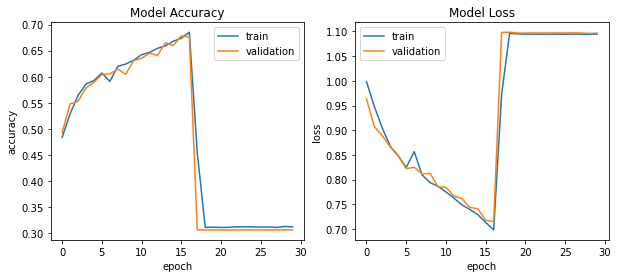

In [38]:
import matplotlib.pyplot as plt
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [ ]:
np.version.version

In [ ]:
tf.__version__

In [ ]:
pip install -U numpy==1.18.5 --user

In [ ]:
pip uninstall pycocotools

In [ ]:
pip install pycocotools-windows

In [ ]:
pd.__version__